# MTH3302 - Méth. prob. et statist. pour l’intel. artif.
# Projet final - Equipe 2


### Membres de l'équipe
    - Amine BELLAHSEN 
    - Sanae LOTFI 
    - Paul MICHELON
    - Théo Moins 

# Contexte et Introduction

Nous présentons dans ce document notre méthode de prédicition des ventes globales et nord-américaines pour le jeu de données fourni par le concours Kaggle *FINAL MTH3302 - A2018*.

Notre approche s'est construite autour des axes suivants :
* **Analyse des données :** cette première partie propose un aperçu global du dataset, afin de percevoir ses caractéristiques principales et d'avoir une première idée des méthodes adaptées au problème demandé.
* **Traitement des données :** on traite ici des opérations que nous effectuons sur le dataset avant de mettre en oeuvre un modèle prédictif. Il s'agit ici de traiter les valeurs manquantes, d'encoder les variables catégoriques et de normaliser le dataset.
* **Régression linéaire :** on effectue des régressions linéaires sur l'ensemble de données traitées dans la précédente partie. On calcule également les indicateurs principaux de nos régressions pour savoir si elles sont significatives. On réalise ensuite une sélection de modèles en utilisant plusieurs méthodes.
* **Composantes principales et régression :** on présente ici une approche par régression linéaire utilisant une analyse en composantes principales pour s'affranchir de la multicolinéarité et pour ne conserver que les variables les plus pertinentes.
* **Analyse de la régression par ACP :** on réalise une analyse des résultats obtenus avec la régression par composantes principales. Nous commençons par tracer la courbe d'ajustement de notre modèle dans l'objectif de détecter un régime de sur ou sous apprentissage. Nous déterminons ensuite les éventuels éléments suspects de notre ensemble de données. Nous élaborons en fin de partie une ouverture sur une amélioration de notre modèle pour mieux prendre en compte les valeurs extrêmes.
* **Régression linéaire par classe d'une variable qualitative :** cette partie traite de la méthode utilisant différentes régressions linéaires par variables qualitatives (Genre, Publisher etc...).
* **Utilisation de la corrélation entre NA Sales et Global Sales :** nous explorons dans cette partie une méthode utilisant NA Sales pour prédire Global Sales.
* **Evolution du résultat et Conclusions :** nous faisons un récapitulatif des résultats obtenus tout au long des semaines du concours, tout en portant un regard critique sur nos réalisation.

# I. Analyse et découverte des données: 

Nous commençons par faire appel à toutes les bibliothèques qui seront nécessaires pour la première partie de notre travail.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error
from pandas.plotting import scatter_matrix
import pandas as pd
import seaborn as sns

On charge les fichiers de données:

In [2]:
X_train = pd.read_csv("train3.csv")
X_test = pd.read_csv("test3.csv")

Examinons la forme des données desquelles on dispose:

In [3]:
X_train.head()

,ID,Name,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,NA_Sales,Global_Sales
0,1,Zoo Keeper,DS,2004.0,Puzzle,Ignition Entertainment,0.050524,0.010024,74.0,40.0,7.5,13.0,Buddiez- Inc.,E,0.101432,0.172605
1,2,Do-Konjou Shougakussei: Bon Bita - Hadaka no C...,DS,2010.0,Action,Namco Bandai Games,0.039211,0.001791,NaN,NaN,NaN,NaN,NaN,NaN,0.000440,0.043251
2,3,Power Play Pool,DS,2006.0,Sports,System 3 Arcade Software,0.000374,0.001797,NaN,NaN,NaN,NaN,System 3,E,0.030829,0.041271
3,4,SpongeBob SquarePants: Revenge of the Flying D...,PS2,2002.0,Platform,THQ,0.001382,0.140010,NaN,NaN,6.6,41.0,Big Sky Software,E,0.528330,1.080821
4,5,Deception IV: Blood Ties,PSV,2014.0,Action,Tecmo Koei,0.069422,0.009535,67.0,19.0,7.5,61.0,Koei Tecmo Games,M,0.020629,0.131074


Décrivons les colonnes de notre fichier de données en faisons la différence entre les variables à prédire et les variables explicatives (en complétant cette description par les informations disponibles sur Kaggle):

<b> Variables à prédire:</b>

- NA_sales [Variable quantitative] : Nombre de ventes du jeu en Amérique du Nord en millions d’unités.  
- Global_Sales [Variable quantitative] : Nombre de ventes total du jeu en millions d’unités.  


<b> Variables explicatives: </b>

- Name [Variable qualitative]: Nom du jeu.
- Platform [Variable qualitative] : Console sur laquelle le jeu fonctionne.  
- Year of release [Variable quantitative]: Année de sortie du jeu.  
- Genre [Variable qualitative] : le genre du jeu (Action, puzzle ...etc).  
- Publisher [Variable qualitative] : Entreprise d'édition.  
- JP_sales [Variable quantitative] : Nombre de ventes du jeu au Japon en millions d’unités.  
- Other sales [Variable quantitative] : Nombre de ventes du jeu ailleurs dans le monde : Afrique, Asie sans le Japon, Europe sans l’Union Européenne et Amérique du Sud en millions d’unités.  
- Critic_score [Variable quantitative] : Score donné par Metacritic.  
- Critic_count [Variable quantitative] : Nombre de critiques prises en compte pour estimer le Critic_score.  
- User_Score [Variable quantitative]: Score donné par les usagers de Metacritic.  
- User_Count [Variable quantitative]: Nombre d’usagers considérés pour estimer le User_Score.  
- Developer [Variable qualitative]: Compagnie créatrice du jeu.  
- Rating [Variable qualitative] : Classement ESRB (Entertainment Software Rating Board) ie à qui s’addresse le jeu (tout public, majeur, adolescents, etc).  

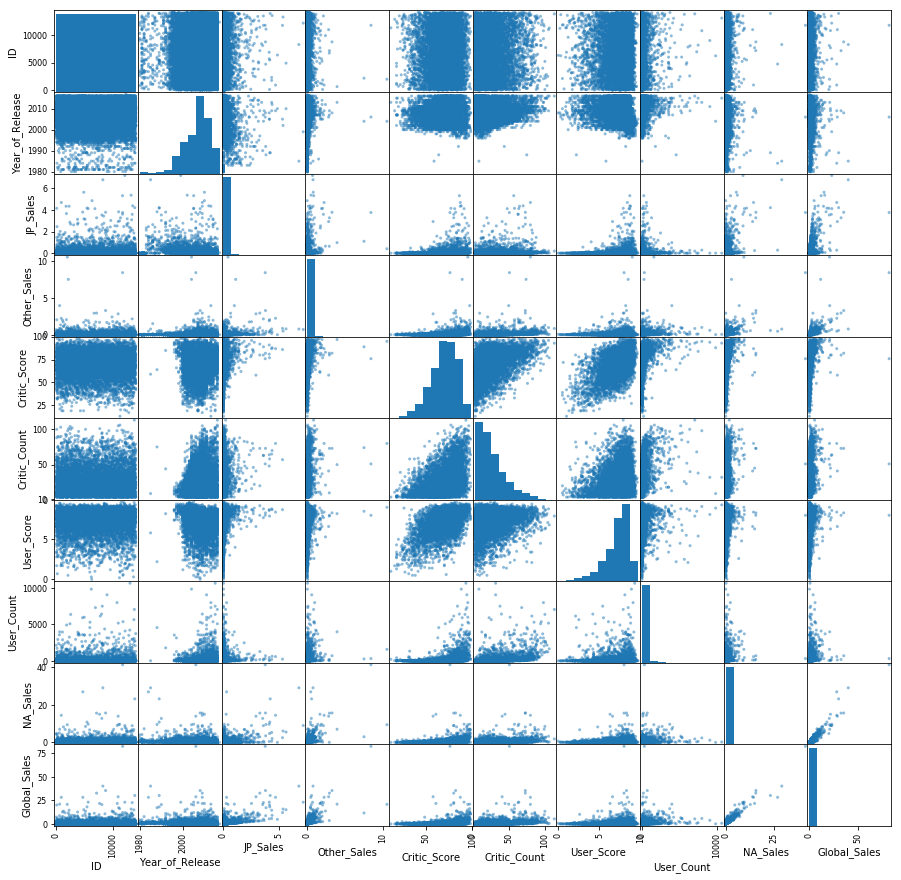

In [4]:
scatter_matrix(X_train, figsize = (15, 15))
plt.show()

Nous remarquons d'après ce plot que la relation entre les 2 variables à prédire, c'est-à-dire "NA Sales" et "Global Sales" semble être linéaire. Par ailleurs, nous faisons la même remarque concernant la relation entre "critic score" et "user score".

Pour analyser plus en détails et d'une façon pertinente ces correlations, affichons la matrice de corrélation entre nos variables (code inspiré d'une réponse sur stackoverflow(ref.1), voir références):

In [5]:
%matplotlib inline

# calculate the correlation matrix
corr = X_train.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Matrice de Corrélation")\
    .set_precision(2)\

,ID,Year_of_Release,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count,NA_Sales,Global_Sales
ID,1,0.00074,0.018,0.002,0.0056,0.02,0.00017,0.018,0.022,0.019
Year_of_Release,0.00074,1,-0.17,0.037,0.0082,0.23,-0.26,0.18,-0.095,-0.078
JP_Sales,0.018,-0.17,1,0.27,0.16,0.19,0.13,0.079,0.44,0.59
Other_Sales,0.002,0.037,0.27,1,0.19,0.24,0.059,0.23,0.62,0.74
Critic_Score,0.0056,0.0082,0.16,0.19,1,0.43,0.58,0.27,0.24,0.24
Critic_Count,0.02,0.23,0.19,0.24,0.43,1,0.2,0.36,0.29,0.3
User_Score,0.00017,-0.26,0.13,0.059,0.58,0.2,1,0.041,0.091,0.093
User_Count,0.018,0.18,0.079,0.23,0.27,0.36,0.041,1,0.23,0.25
NA_Sales,0.022,-0.095,0.44,0.62,0.24,0.29,0.091,0.23,1,0.94
Global_Sales,0.019,-0.078,0.59,0.74,0.24,0.3,0.093,0.25,0.94,1


Rappelons que la formule de la correlation entre 2 variables est la suivante : $corr(X,Y) = \frac{cov(X,Y)}{\sigma_X\sigma_Y}$

Par conséquent, la matrice de corrélation contiendra 1 sur la diagonale, et la corrélation empirique entre toutes les variables aléatoires.

Nous observons que les 4 différents types de ventes sont fortement corrélées entre eux. Les scores le sont également un peu entre eux, mais globalement il semblerait qu'il y ait très peu de corrélation entre les différentes *features*.

Nous envisagerons par la suite faire une ACP (analyse par composantes principales) pour éviter tout effet de multicolinéarité possible.

# II. Traitement des données

Le premier axe de traitement des données sera le traitement des valeurs manquantes. Récupérons d'abord le nombre de valeurs manquantes pour différentes variables dans le fichier test et train.

### II.1. Traitement des valeurs manquantes:

In [6]:
na_train = X_train.isna().sum().sort_values(ascending=False)
na_test = X_test.isna().sum().sort_values(ascending=False)
print("Valeurs manquantes par variable pour le fichier train :",
      "\n\n", na_train.dropna())
print("\n", "Valeurs manquantes par variable pour le fichier test :",
      "\n\n", na_test.dropna())

Valeurs manquantes par variable pour le fichier train : 

 User_Count         7653
User_Score         7653
Critic_Count       7186
Critic_Score       7186
Rating             5677
Developer          5556
Year_of_Release     232
Publisher            49
Genre                 2
Name                  2
Global_Sales          0
NA_Sales              0
Other_Sales           0
JP_Sales              0
Platform              0
ID                    0
dtype: int64

 Valeurs manquantes par variable pour le fichier test : 

 User_Count         1370
User_Score         1370
Critic_Count       1292
Critic_Score       1292
Rating              994
Developer           969
Year_of_Release      35
Publisher             4
Other_Sales           0
JP_Sales              0
Genre                 0
Platform              0
ID                    0
dtype: int64


Pour les variables quantitatives, nous faisons les choix suivants pour compléter les valeurs manquantes pour les différentes variables:

- User Count: nous choisissons de compléter les valeurs manquantes de cette variable par la moyenne du User Count des observations existentes. Cependant, nous estimons que cette variable pourrait être très importante dans la justifications des variables à prédire et donc nous devons garder l'information sur la véracité de la valeur de cette variable. Nous choisissons alors de rajouter une variable qualitative "present user count" qui indique si le "count" était présent avant le traitement des données ou il est complété par la moyenne.

- User Score: nous choisissons de compléter  les valeurs manquantes de cette variable par la moyenne du User score des observations existentes également. Nous faisons le même choix de rajouter une variable qualitative "present user score" qui indique si le "score" était présent avant le traitement des données ou il est complété par la moyenne.

- Critic Count: les valeurs manquantes cette variable sont traitées de la même manière que les variables précédentes.  

- Critic Score : les valeurs manquantes cette variable sont traitées de la même manière que les variables précédentes.  

- Year of release : les valeurs manquantes cette variable sont traitées de la même manière que les variables précédentes.  

Définissons alors la fonction "parse_absent" qui nous permettra de créer les variables additionnelles:

In [7]:
def parse_absent(x):
    if pd.isnull(x):
        return "absent"
    else:
        return "present"

Pour les variables catégoriques, nous choisissons de rajouter une nouvelle catégorie "Unknown" pour éviter de fausser les valeurs de ces variables en remplaçant les valeurs manquantes par la catégorie dominante. Cela concerne les variables catégoriques: "Rating", "Developer", "Publisher", "Genre".

Concernant la variable "Name", nous remarquons qu'au plus 12 jeux du fichier entraînement partagent le même nom. Ceci est très peu sachant que le fichier contient 14094 jeux (le fait qu'il y aie plusieurs fois le même nom s'explique par le fait qu'il y a une ligne par plateforme). 

Nous faisons alors le choix de ne pas inclure cette variable parmi les variables explicatives que nous utiliserons par la suite.

In [8]:
X_train.shape

(14094, 16)

In [9]:
X_train["Name"].value_counts().sort_values(ascending = False).head()

Need for Speed: Most Wanted    12
FIFA 14                         9
Madden NFL 07                   9
Madden NFL 08                   8
Ratatouille                     8
Name: Name, dtype: int64

La 2ème partie très importante dans le traitement des données est l'encodage des variables catégoriques.

### II.2. Encodage des variables catégoriques:

#### II.2.1. Encodage de la variable "Developer":


Examinons le nombre de classes uniques/ non redondantes pour cette variable: 

In [10]:
print('classes de Developer dans train: ', X_train.Developer.unique().size)
print('classes de Developer dans test: ', X_test.Developer.unique().size)

classes de Developer dans train:  1594
classes de Developer dans test:  678


Le nombre des classes est très grand, donc il serait impossible d'encoder toutes ces classes en tant que variables binaires.
Nous faisons alors le choix de ne garder que les classes qui représentent un grand nombre de jeux (seuil déterminé de sorte qu'on réduit considérablement le nombre de classes à encoder). Pour regroupons toutes les classes restantes sous le nom "Other".

In [11]:
X_train["Developer"].value_counts().sort_values(ascending = False)

Ubisoft                                             171
EA Sports                                           147
EA Canada                                           140
Konami                                              139
Capcom                                              115
EA Tiburon                                           93
Electronic Arts                                      86
Ubisoft Montreal                                     86
Visual Concepts                                      86
Vicarious Visions                                    66
Nintendo                                             65
Traveller's Tales                                    64
Omega Force                                          64
THQ                                                  62
Activision                                           60
Midway                                               56
TT Games                                             54
Codemasters                                     

Nous choisissons alors de garder les 14 Classes les plus représentées dans l'ensemble d'entrainement. 
Le nombre 15 a été choisi qualitativement : il faut trouver un compromis entre un nombre de variables restreint pour éviter d'avoir trop de variables pour l'encodage, mais quand même être en mesure de caractériser une proportion de jeux non négligeable autrement que par "Unknown".

La fonction suivante nous permet de faire cette réduction du nombre des classes pour la variable "developer":

In [12]:
def reduce_developer(x):
    keep_list = X_train["Developer"].value_counts().sort_values(ascending = False).index.tolist()[1:15]
    keep_list.append("Unknown")
    if x not in keep_list:
        return "Other"
    else:
        return x

Nous utiliserons le "One Hot Encoding" qui consiste à remplacer chaque classe par un vecteur qui contient 1 pour la classe correspendante et des zéros pour les autres classes. Ainsi, on remplacera une feature catégorique pouvant prendre 3 valeurs différentes, par 3 features catégoriques pouvant prendre les valeurs 0 ou 1.

Nous allons suivre ces mêmes étapes pour réduire le nombre des classes pour toutes les autres variables catégoriques à encoder.

#### II.2.2. Encodage de la variable "Publisher":


- Examiner le nombre de classes uniques/ non redondantes pour cette variable: 

In [13]:
print('Nombre de classes de Publisher dans train: ', X_train.Publisher.unique().size)
print('Nombre de classes de Publisher dans test: ', X_test.Publisher.unique().size)

Nombre de classes de Publisher dans train:  553
Nombre de classes de Publisher dans test:  281


- Déterminer les classes à garder:

In [14]:
X_train["Publisher"].value_counts().sort_values(ascending = False)

Electronic Arts                           1147
Activision                                 833
Namco Bandai Games                         798
Ubisoft                                    774
Konami Digital Entertainment               706
THQ                                        591
Nintendo                                   589
Sony Computer Entertainment                584
Sega                                       535
Take-Two Interactive                       358
Capcom                                     323
Atari                                      312
Tecmo Koei                                 299
Square Enix                                205
Warner Bros. Interactive Entertainment     186
Disney Interactive Studios                 184
Eidos Interactive                          178
Unknown                                    172
Midway Games                               165
Microsoft Game Studios                     163
505 Games                                  161
Acclaim Enter

Nous choisissons de garder les 9 premières classes: "Electronic Arts", "Activision", "Namco Bandai Games", "Ubisoft", "Konami Digital Entertainment", "THQ", "Nintendo", "Sony Computer Entertainment", "Sega".

- Ecrire la fonction suivante nous permet de faire cette réduction du nombre des classes pour la variable "Publisher":

In [15]:
def reduce_publisher(x):
    keep_list = X_train["Publisher"].value_counts().sort_values(ascending = False).index.tolist()[1:10]
    keep_list.append("Unknown")
    if x not in keep_list:
        return "Other"
    else:
        return x

- Le "One Hot Encoding" est choisi pour encoder cette variable.

#### II.2.3. Encodage de la variable "Rating":


- Examiner le nombre de classes uniques/ non redondantes pour cette variable: 

In [16]:
print('classes de Rating dans train: ', X_train.Rating.unique().size)
print('classes de Rating dans test: ', X_test.Rating.unique().size)

classes de Rating dans train:  9
classes de Rating dans test:  6


- Déterminer les classes à garder:

In [17]:
X_train["Rating"].value_counts().sort_values(ascending = False)

E       3369
T       2515
M       1325
E10+    1195
EC         7
K-A        3
RP         2
AO         1
Name: Rating, dtype: int64

Nous choisissons de garder les classes suivantes: "E", "T", "M" et "E10+". Les classes restantes sont encodées en tant que "other".

- Ecrire la fonction suivante nous permet de faire cette réduction du nombre des classes pour la variable "Rating":

In [18]:
def reduce_rating(x):
    keep_list = ["E", "T", "M", "E10+", "Unknown"]
    if x not in keep_list:
        return "Other"
    else:
        return x

- Le "One Hot Encoding" est choisi pour encoder cette variable.

#### II.2.4. Encodage de la variable "Platform":


- Examiner le nombre de classes uniques/ non redondantes pour cette variable:

In [19]:
print('classes de Platform dans train: ', X_train.Platform.unique().size)
print('classes de Platform dans test: ', X_test.Platform.unique().size)

classes de Platform dans train:  30
classes de Platform dans test:  27


- Déterminer les classes à garder:

In [20]:
X_train["Platform"].value_counts().sort_values(ascending = False)

PS2     1861
DS      1807
PS3     1143
Wii     1109
X360    1042
PSP     1031
PS      1010
PC       801
GBA      696
XB       696
GC       472
3DS      432
PSV      356
PS4      319
N64      265
XOne     216
SNES     191
SAT      151
WiiU     121
2600     111
GB        85
NES       84
DC        43
GEN       25
NG        12
SCD        6
WS         4
TG16       2
3DO        2
PCFX       1
Name: Platform, dtype: int64

Là encore, nous choisissons de garder les 14 variables les plus représentés.

- Ecrire la fonction suivante nous permet de faire cette réduction du nombre des classes pour la variable "Platform":

In [21]:
def reduce_platform(x):
    keep_list = X_train["Platform"].value_counts().sort_values(ascending = False).index.tolist()[1:15]
    if x not in keep_list:
        return "Other"
    else:
        return x

- Le "One Hot Encoding" est choisi pour encoder cette variable.

### II.3. Normalisation:

La normalisation permet d'exprimer la colonne sous-forme d'une distribution normale centrée en 0 et de variance 1. L'intérêt de réduire ainsi les features est de les mettre toutes à la même échelle. En effet, certains algorithmes de classification auront tendance à considérer des colonnes avec des petites valeurs comme négligeable par rapport à des colonnes avec de grandes, et ainsi à l'ignorer lors de l'apprentissage (ref.2).

Nous faisons alors le choix de normaliser toutes les variables explicatives quantitatives.

### II.4 Transformation des données

Nous devons alors appliquer les transformations décrites dans les paragraphes précedents. Nous pouvons faire cela d'une façon classique en effectuant une transformation après l'autre, variable par variable.

Cependant, nous choisissons d'exploiter le principe du "pipeline" (ref.2). En effet, l'implémentation d'une transformation après l'autre est fastidieuse et redondante (elle nécessite beaucoup de copier-coller). D'autre part, si on voulait effectuer une modification dans le processus de traitement des données et tester son impact sur la performance, il faudrait tout relancer manuellement sans rien oublier. Une solution existe dans sklearn pour pallier à ce problème, c'est ce qu'on appelle "le pipeline". Il permet de lister la liste des transformations par colonne et de les appliquer en une seule fois (ref.2).

#### Suppression de colonnes non traitées :

In [22]:
'''
Suppression de :
    - ID
    - Name
''' 

# garder le ID dans la dataframe des résultats
results = pd.DataFrame()
results['ID'] = X_test['ID']

# supprimer les colonnes ID et name
Names = X_train.Name
X_train = X_train.drop(columns = ["ID", "Name"])
X_test = X_test.drop(columns = ["ID"])

# Extraction de la feature à prédire, et stockage dans y_train :
y_train = X_train[["NA_Sales", "Global_Sales"]]
X_train = X_train.drop(columns = ["NA_Sales", "Global_Sales"])

Vérification de la suppression

In [23]:
X_train.head()

,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,DS,2004.0,Puzzle,Ignition Entertainment,0.050524,0.010024,74.0,40.0,7.5,13.0,Buddiez- Inc.,E
1,DS,2010.0,Action,Namco Bandai Games,0.039211,0.001791,NaN,NaN,NaN,NaN,NaN,NaN
2,DS,2006.0,Sports,System 3 Arcade Software,0.000374,0.001797,NaN,NaN,NaN,NaN,System 3,E
3,PS2,2002.0,Platform,THQ,0.001382,0.140010,NaN,NaN,6.6,41.0,Big Sky Software,E
4,PSV,2014.0,Action,Tecmo Koei,0.069422,0.009535,67.0,19.0,7.5,61.0,Koei Tecmo Games,M


In [24]:
y_train.head()

,NA_Sales,Global_Sales
0,0.101432,0.172605
1,0.000440,0.043251
2,0.030829,0.041271
3,0.528330,1.080821
4,0.020629,0.131074


#### Le Pipeline

Ecrivons alors le pipeline définie ci-dessus qui nous permettra d'effectuer toutes les transformations à la fois.  
##### Le fichier preprocessing est un fichier externe que le correcteur trouvera dans le zip avec ce notebook.

In [25]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from preprocessing import TransformationWrapper
from preprocessing import LabelEncoderP
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

# Process Plateform

pipeline_platform = Pipeline([
    ("fillna", SimpleImputer(strategy = 'constant', fill_value = "Unknown")),
    ("Platform", TransformationWrapper(transformation = reduce_platform)),
    ("encode",OneHotEncoder(categories = 'auto', sparse = False))
])

# Process Rating

pipeline_rating = Pipeline([
    ("fillna", SimpleImputer(strategy = 'constant', fill_value = "Unknown")),
    ("developer", TransformationWrapper(transformation = reduce_rating)),
    ("encode",OneHotEncoder(categories = 'auto', sparse = False))
])

# Process Developer

pipeline_Developer = Pipeline([
    ("fillna", SimpleImputer(strategy = 'constant', fill_value = "Unknown")),
    ("developer", TransformationWrapper(transformation = reduce_developer)),
    ("encode",OneHotEncoder(categories = 'auto', sparse = False))
])

# Process user count


pipeline_absent_user_count = Pipeline([
    ("absent_user_count", TransformationWrapper(transformation = parse_absent)),
    ("encode",LabelEncoderP()),
])


pipeline_userCount = Pipeline([
    ("fillna", SimpleImputer(strategy = 'mean')),
    ("scaler",StandardScaler())
])


pipeline_User_Count = Pipeline([
    
    ('feats', FeatureUnion([
        ('absent_user_count', pipeline_absent_user_count), 
        ('user_count', pipeline_userCount)
    ])),
    
])


# Process critic count

pipeline_absent_critic_count = Pipeline([
    ("absent_critic_count", TransformationWrapper(transformation = parse_absent)),
    ("encode",LabelEncoderP()),
])

pipeline_criticCount = Pipeline([
    ("fillna", SimpleImputer(strategy = 'mean')),
    ("scaler",StandardScaler())
])


pipeline_Critic_Count = Pipeline([
    
    ('feats', FeatureUnion([
        ('absent_critic_count', pipeline_absent_critic_count), 
        ('critic_count', pipeline_criticCount)
    ])),
    
])

# process Publisher 

pipeline_Publisher = Pipeline([
    ("fillna", SimpleImputer(strategy = 'constant', fill_value = "Unknown")),
    ("publisher", TransformationWrapper(transformation = reduce_publisher)),
    ("encode",OneHotEncoder(categories = 'auto', sparse = False))
])

# Process the year


pipeline_absent_year = Pipeline([
    ("absent_user_year", TransformationWrapper(transformation = parse_absent)),
    ("encode",LabelEncoderP()),
])


pipeline_year_process = Pipeline([
    ("fillna", SimpleImputer(strategy = 'mean')),
    ("scaler",StandardScaler())
])


pipeline_Year = Pipeline([
    
    ('feats', FeatureUnion([
        ('absent_year', pipeline_absent_year), 
        ('year', pipeline_year_process)
    ])),
    
])

# Process genre

pipeline_Genre = Pipeline([
    ("fillna", SimpleImputer(strategy = 'constant', fill_value = "Unknown")),
    ("encode",OneHotEncoder(categories = 'auto', sparse = False))
])

# process JP Sales

pipeline_JP_Sales = Pipeline([
    ("fillna", SimpleImputer(strategy = 'mean')),
    ("scaler",StandardScaler())
])

# Process Other Sales
pipeline_Other_Sales = Pipeline([
    ("fillna", SimpleImputer(strategy = 'mean')),
    ("scaler",StandardScaler())
])

# Process Critic score
pipeline_absent_critic = Pipeline([
    ("absent_critic_score", TransformationWrapper(transformation = parse_absent)),
    ("encode",LabelEncoderP()),
])

pipeline_critic = Pipeline([
    ("fillna", SimpleImputer(strategy = 'mean')),
    ("scaler",StandardScaler())
])



pipeline_Critic_Score = Pipeline([
    
    ('feats', FeatureUnion([
        ('absent_critic_score', pipeline_absent_critic), 
        ('critic_score', pipeline_critic)
    ])),
    
])

# Process User Score

pipeline_absent_user = Pipeline([
    ("absent_user_score", TransformationWrapper(transformation = parse_absent)),
    ("encode",LabelEncoderP()),
])


pipeline_user = Pipeline([
    ("fillna", SimpleImputer(strategy = 'mean')),
    ("scaler",StandardScaler())
])


pipeline_User_Score = Pipeline([
    
    ('feats', FeatureUnion([
        ('absent_user_score', pipeline_absent_user), 
        ('user_score', pipeline_user)
    ])),
    
])

# Write the entire pipeline

full_pipeline = ColumnTransformer([
        ("User_Count", pipeline_User_Count, ["User_Count"]),
        ("Critic_Count", pipeline_Critic_Count, ["Critic_Count"]),
        ("Year_of_Release", pipeline_Year, ["Year_of_Release"]),
        ("JP_Sales", pipeline_JP_Sales, ["JP_Sales"]),
        ("Other_Sales", pipeline_Other_Sales, ["Other_Sales"]),
        ("Critic_Score", pipeline_Critic_Score, ["Critic_Score"]),
        ("User_Score", pipeline_User_Score, ["User_Score"]),
        ("Genre", pipeline_Genre, ["Genre"]),
        ("Rating", pipeline_rating, ["Rating"]),
        ("Publisher", pipeline_Publisher, ["Publisher"]),
        ("Developer", pipeline_Developer, ["Developer"]),
        ("Platform", pipeline_platform, ["Platform"])
    ])

Appliquons maintenant ce pipeline sur les 2 ensembles d'entraînement et de test: 

In [26]:
import copy
import warnings
warnings.filterwarnings("ignore")

column_names = ['Present_User_Count', 'User_Count', 'Present_Critic_Count',
                'Critic_Count', 'Present_Year_of_Release',
                'Year_of_Release','JP_Sales', 'Other_Sales', 'Present_Critic_Score',
                'Critic_Score','Present_User_Score',
                'User_Score']


for i in range(X_train.Genre.unique().size):
    column_names.append('Genre'+str(i+1))

for i in range(1,7):
    column_names.append('Rating'+str(i))
    
for i in range(1,12):
    column_names.append('Publisher'+str(i))

for i in range(1,17):
    column_names.append('Developer'+str(i))
    
for i in range(1,16):
    column_names.append('Platform'+str(i))
    
X_train_prepared = pd.DataFrame(full_pipeline.fit_transform(X_train),columns = column_names)
nan_series = pd.Series([np.nan for i in range(X_test.shape[1])], index=X_test.columns)
X_test_prepared = X_test
X_test_prepared = X_test_prepared.append(nan_series, ignore_index = True)
X_test_prepared = pd.DataFrame(full_pipeline.fit_transform(X_test_prepared),columns = column_names)
X_test_prepared = X_test_prepared.drop(X_test_prepared.index[len(X_test_prepared)-1])

On voit déjà ici pourquoi on se limite dans le nombre de variables conservés : le temps de traitement est déjà relativement long avec les choix de traitement effectués plus haut. 

In [27]:
len(X_test_prepared.columns)

73

In [28]:
X_test_prepared.head()

,Present_User_Count,User_Count,Present_Critic_Count,Critic_Count,Present_Year_of_Release,Year_of_Release,JP_Sales,Other_Sales,Present_Critic_Score,Critic_Score,...,Platform6,Platform7,Platform8,Platform9,Platform10,Platform11,Platform12,Platform13,Platform14,Platform15
0,1.0,-0.380294,1.0,-1.171481e+00,1.0,-0.775435,-0.220556,-0.280090,1.0,-4.726214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-0.344527,1.0,6.520491e-01,1.0,0.240319,-0.219423,-0.162062,1.0,0.343954,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,-2.699367e-16,1.0,-1.621897,0.439013,0.004269,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,-0.310864,1.0,-4.876574e-01,1.0,-0.775435,-0.219623,-0.233292,1.0,1.294610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.021558,1.0,3.159403e+00,1.0,0.578904,-0.220764,-0.054937,1.0,-0.606703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Maintenant que nos données sont prêtes à exploiter, nous allons faire des premiers essais de prédiction.

# III. Régression Linéaire - Choisir le meilleur sous-modèle 

## A. Régression Linéaire

Nous savons que l'apprentissage supervisé consiste à supposer que notre variable d'intérêt Y (ici Global Sales ou NA Sales) est donnée par: $Y = f(X) + \epsilon$, où  $f$ est une fonction inconnue et non aléatoire de $X_1, . . . , X_p$, nos variables traitées dans la section précédente (dans ce cas, $p=73$). $\epsilon$ est une erreur aléatoire supposée indépendante de X, de moyenne nulle.

Dans le cadre de ce projet, nous commençons par tester le modèle de régression linéaire. Cela revient à supposer que la fonction $f$ est de la forme : $f (X) = \beta_0 + \beta_1 X_1 + · · · + \beta_p X_p$. Les $\beta$ sont les coefficients de régression. On souhaite alors estimer la fonction f par une fonction $\tilde{f}$, ce qui revient dans ce cas à estimer les $\beta$. La méthode la plus connue pour estimer ces paramètres est la méthode des moindres carrés. Cette méthode consiste à choisir les $\beta$ qui minimisent le RSS : Residual Sum of Squares $RSS(\beta) = (y - X \beta)^T (y - X \beta)$, où $\beta$ est le vecteur des $(\beta_0, \beta_1, ..., \beta_p)^T)$, $y$ est la variables à prédire et $X$ est la matrice des variables explicatives avec une première colonne de $1$.

Utilisons alors la librairie statsmodels.api existante dans Python pour ajuster un modèle de régression linéaire pour les 2 variables cibles avec 73 variables explicatives:

<b> Régression linéaire pour Global Sales: </b>

In [29]:
import statsmodels.api as sm
X = sm.add_constant(X_train_prepared)
model_global_sales = sm.OLS(y_train.Global_Sales, X).fit()
model_na_sales = sm.OLS(y_train.NA_Sales, X).fit()

print(model_global_sales.summary())

                            OLS Regression Results                            
Dep. Variable:           Global_Sales   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     595.9
Date:                Thu, 13 Dec 2018   Prob (F-statistic):               0.00
Time:                        23:24:51   Log-Likelihood:                -16684.
No. Observations:               14094   AIC:                         3.350e+04
Df Residuals:                   14027   BIC:                         3.401e+04
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

<b> Analyse: </b> Le sommaire est très riche et nous permet de faire une analyse détaillée. En effet:

- le $R^2$, définie en tant que le rapport de la variabilité expliquée par le modèle sur la variabilité totale, est égal à 0.736. Cela signifie que le modèle de régression linéaire arrive à expliquer 73% de la variabilité, ce qui est un pourcentage plutôt admissible.
- le $R^2$ ajusté, qui est un indice adapté de $R^2$ en prenant en compte le nombre de variables est aussi de 73%, ce qui représente unbon pourcentage.
- Le test statistique F qui permet de dire si la régression linéaire est significative a une p-value < 5%. Cela nous permet de rejeter l'hypothèse nulle, qui affirme que la régression linéaire n'est pas significative.
- Nous remarquons par contre que les p-values des différentes variables explicatives ne sont pas toutes inférieures au seuil critique que nous choisissons de 5% $\implies$ une réduction du nombre des variables s'impose par la suite.
- Le 2ème warning indique qu'il est possible que la multicolinéarité soit présente pour notre problème. Encore une fois, une réduction du nombre des variables s'impose par la suite.

Passons maintenant à l'analyse des résultats pour NA Sales:

<b> Régression linéaire pour NA Sales: </b>

In [30]:
print(model_na_sales.summary())

                            OLS Regression Results                            
Dep. Variable:               NA_Sales   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     223.4
Date:                Thu, 13 Dec 2018   Prob (F-statistic):               0.00
Time:                        23:24:51   Log-Likelihood:                -12352.
No. Observations:               14094   AIC:                         2.484e+04
Df Residuals:                   14027   BIC:                         2.534e+04
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

<b> Analyse: </b> Pour cette 2ème variable cible, nous constatons que:

- le $R^2$ est égal à 0.509. Cela signifie que le modèle de régression linéaire explique seulement 50% de la variabilité de la varible cible, ce qui est un pourcentage plutôt faible.
- le $R^2$ ajusté est aussi de l'ordre de 50% : pourcentage faible également.
- Le test statistique F qui permet de dire si la régression linéaire est significative a une p-value < 5%. Cela nous permet de rejeter l'hypothèse nulle, qui affirme que la régression linéaire n'est pas significative. Donc la régression est significative même si le $R^2$ ajusté est faible.
- Comme pour le cas précédent, nous remarquons par contre que les p-values des différentes variables explicatives ne sont pas toutes inférieures au seuil critique que nous choisissons de 5% $\implies$ une réduction du nombre des variables s'impose par la suite.
- Comme pour le cas précédent, le 2ème warning indique qu'il est possible que la multicolinéarité soit présente pour notre problème. Encore une fois, une réduction du nombre des variables s'impose par la suite.

Nous avons obtenu des résultats moyens en utilisons ce modèle simple. Dans la section suivante, nous allons essayer de sélectionner un sous-ensemble de variables qui permettrait d'améliorer le $R^2$ ajusté.

## B. Choisir le meilleur sous-modèle 

### III.1 Sélection par meilleur sous-ensemble en comparant tous les sous-ensembles

Une manière efficace de choisir le meilleur sous-ensemble de variables serait d'ajuster tous les modèles de régression possibles à p variables, p allant de 0 à 73. Cependant, ce n'est pas raisonnable de faire cela. La dataframe préparée contient 73 variables. Cela fait $2^{73}$ modèles à comparer !!! Nous allons alors avoir recours à une sélection ascendante des variables à garder.

### III.2 Méthode de sélection ascendante

La sélection débute avec le modèle sans variable, on y ajoute successivement des variables. 

L'algorithme utilisé est le suivant:

1. On note $M_0$ le modèle sans variables,
2. Pour k = 1, 2, . . . , p − 1
 - 2.1 on considère tous les p − k modèles qui augmentent de 1 le nombre de variables dans $M_k$
 - 2.2 on choisit le meilleur des p − k modèles, noté $M_{k+1}$, selon le RSS .
3. on choisit le meilleur modèle parmi M_0,M_1, . . . ,M_p par validation croisée avec des critères tels que R2_ajusté ,C_p, BIC et AIC présentés plus tard.

#### III.2.1 Méthode de sélection ascendante - Pour NA Sales 


Le code suivant permet de faire la sélection du meilleur modèle consistitué de $p$ variables, p allant de 1 à 73:

In [31]:
import itertools


def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared


#Initialization variables
Y = y_train[["NA_Sales"]]
X = X_train_prepared
k = 73

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [32]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['Other_Sales'], 5970.0),
 (2, ['Other_Sales', 'JP_Sales'], 5215.0),
 (3, ['Other_Sales', 'JP_Sales', 'Platform14'], 5159.0),
 (4, ['Other_Sales', 'JP_Sales', 'Platform14', 'Year_of_Release'], 5099.0)]

In [33]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [34]:
#Initializing useful variables
m = len(Y)
p = 73
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1.head()

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[Other_Sales],5969.775287,0.388774,1,0.423617,1.247263,1.247799,0.388731
2,"[Other_Sales, JP_Sales]",5214.712633,0.466083,2,0.370092,1.089668,1.090740,0.466007
3,"[Other_Sales, JP_Sales, Platform14]",5159.099598,0.471777,3,0.366194,1.078192,1.079799,0.471664
4,"[Other_Sales, JP_Sales, Platform14, Year_of_Re...",5098.504732,0.477981,4,0.361943,1.065675,1.067819,0.477833
5,"[Other_Sales, JP_Sales, Platform14, Year_of_Re...",5051.237807,0.482820,5,0.358637,1.055943,1.058622,0.482637


Le tableau ci-dessus donne les variables à sélectionner pour un nombre de variables allant de 1 à 4. Nous avons remarqué pour la matrice de corrélation que Other Sales et JP Sales sont les variables les plus corréléés avec nos variables cibles. Cela est confirmé par le tableau ci-dessus.

In [35]:
print(df1['R_squared_adj'].idxmax())
print(df1['R_squared_adj'].max())

47
0.5106763976068112


Le meilleur R^2 ajusté est de 50% pour 41 variables. Cela ne représente pas une grande amélioration par rapport à la section précédente.

Visualisons maintenant l'évolution des 4 indices: $C_p$, AIC, BIC et $R^2$ ajusté en fonction du nombre des variables:

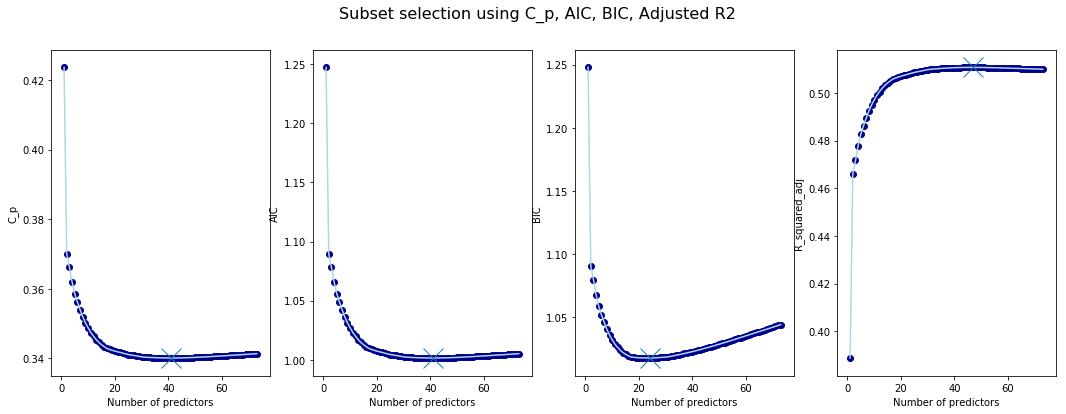

In [36]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

Les 4 indices indiquent que le nombre optimal de variables à choisir est entre 20 et 40. Nous choissons le R^2 ajusté pour sélectionner le sous ensemble des variables à garder, soit 47 variables avec un R^2 ajusté de 51%

#### III.2.2  Méthode de sélection ascendante - Pour Global Sales


On refait une sélection de variables ascendante pour Global Sales:

In [37]:
#Initialization variables
Y = y_train[["Global_Sales"]]
X = X_train_prepared
k = 73

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [38]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['Other_Sales'], 15173.0),
 (2, ['Other_Sales', 'JP_Sales'], 9729.0),
 (3, ['Other_Sales', 'JP_Sales', 'Developer8'], 9551.0),
 (4, ['Other_Sales', 'JP_Sales', 'Developer8', 'Critic_Count'], 9456.0)]

In [39]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [40]:
#Initializing useful variables
m = len(Y)
p = 73
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1.head()

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[Other_Sales],15173.315349,0.547012,1,1.076669,1.714215,1.714751,0.546980
2,"[Other_Sales, JP_Sales]",9728.880440,0.709552,2,0.690464,1.099319,1.100391,0.709510
3,"[Other_Sales, JP_Sales, Developer8]",9550.904469,0.714865,3,0.677925,1.079356,1.080964,0.714804
4,"[Other_Sales, JP_Sales, Developer8, Critic_Count]",9455.580564,0.717711,4,0.671251,1.068729,1.070873,0.717631
5,"[Other_Sales, JP_Sales, Developer8, Critic_Cou...",9378.157055,0.720022,5,0.665846,1.060125,1.062805,0.719923


Le tableau ci-dessus donne les variables à sélectionner pour un nombre de variables allant de 1 à 4. Encore une fois, nous avons remarqué pour la matrice de corrélation que Other Sales et JP Sales sont les variables les plus corréléés avec nos variables cibles. Cela est confirmé par le tableau ci-dessus.

In [41]:
print(df1['R_squared_adj'].idxmax())
print(df1['R_squared_adj'].max())

44
0.736201112928959


Le R^2 ajusté est meilleur pour 36 variables explicatives. Il n'est pas meilleur par rapport à une régression contenant toutes les variables explicatives. Cherchons à voir l'évolution des autres indices également en fonction du nombre des variables:

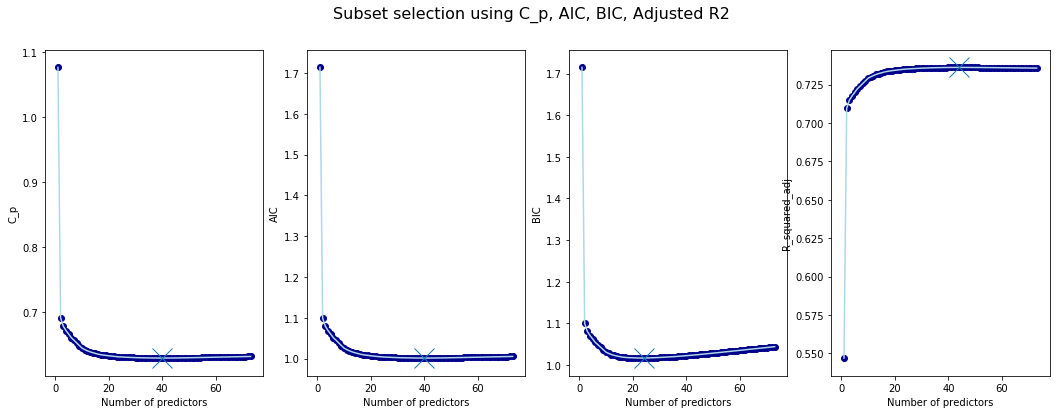

In [42]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

Les 4 indices indiquent que le nombre optimal de variables à choisir est entre 20 et 40. Nous choissons le $R^2$ ajusté pour sélectionner le sous ensemble des variables à garder, soit 44 variables avec un $R^2$ ajusté de 73%

<b> Conclusion : </b>

Cette méthode, bien qu'elle permet de réduire le nombre de variables explicatives à prendre en compte, elle ne nous a pas permis d'améliorer les performances de notre modèle de régression linéaire. Cela peut être dû au fait que ces variables présentent une colinéarité. Le section suivante permettrait de résoudre ce problème puisqu'elle consiste à performer une régression en composantes principales.

# IV. Analyse par Composante Principale et Régression

Pour palier à la multicolinéarité de nos variables, nous effectuons une Analyse par Composante Principale (ACP). 

Le choix du nombre de colonnes se fait par validation croisée : cela nous permet d'éviter de sur-apprendre les données en sélectionnant trop de variables.

### ACP sur l'ensemble des colonnes : 

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

n = X_train_prepared.shape[1]
p = np.zeros(n)

for i in range(0,n):
    pca = PCA(n_components = i+1)
    X_pca = pca.fit_transform(X_train_prepared)
    lm = linear_model.LinearRegression()
    lm.fit(X_pca,y_train.iloc[:,0])
    cross = cross_val_score(lm, X_pca, y_train.iloc[:,0], cv=10, scoring = 'neg_mean_squared_error')
    p[i] = -np.mean(cross)

best = np.argmin(p)+1
print("Nombre de colonnes conservées : " + str(best))

Nombre de colonnes conservées : 5


### Prédictions de NA_Sales et Global_Sales avec cette ACP :

In [44]:
pca = PCA(n_components=best)

X_train_pca = pca.fit_transform(X_train_prepared)

lm1 = linear_model.LinearRegression()
lm1.fit(X_train_pca,y_train.Global_Sales)

lm2 = linear_model.LinearRegression()
lm2.fit(X_train_pca,y_train.Global_Sales)

X_test_pca = pca.transform(X_test_prepared)

pred_NA = lm1.predict(X_test_pca)
pred_Global = lm2.predict(X_test_pca)

### Exportation de la regression : 

Avant d'exporter les résultats, nous effectuons un seuillage des prédictions : en effet, il se peut que l'on prévoit des ventes négatives, ce qui n'a aucun sens, et donc on ramène ces valeurs à 0.

Nous avons tenté pour palier à ce problème différentes transformations, comme par exemple prévoir non pas les ventes mais le logarithme des ventes afin d'avoir des valeurs sur l'ensemble des réels, mais ces méthodes n'ont pas permis d'améliorer le résultat (score élevé par validation croisée)

In [45]:
for i in range(len(pred_NA)):
    if pred_NA[i] < 0:
        pred_NA[i] = 0
    if pred_Global[i] < 0:
        pred_Global[i] = 0


results['NA_Sales'] = pred_NA
results['Global_Sales'] = pred_Global
results.to_csv('results.csv', index = False)

In [46]:
results.head()

,ID,NA_Sales,Global_Sales
0,14095,0.237941,0.237941
1,14096,0.431635,0.431635
2,14097,0.848696,0.848696
3,14098,0.211170,0.211170
4,14099,1.029939,1.029939


### Score par validation croisée :

Tout au long du projet, nous visualisons la performance de nos modèles en observant le score par validation croisée. Voici celui que l'on a avec les choix que l'on a fait jusque ici :

In [47]:
print("MSE Pour NA_Sales par CV :", -np.mean(cross_val_score(lm1, X_train_pca, y_train.NA_Sales, cv=5, scoring = 'neg_mean_squared_error')))
print("MSE Pour Global_Sales par CV :", -np.mean(cross_val_score(lm2, X_train_pca, y_train.Global_Sales, cv=5, scoring = 'neg_mean_squared_error')))

MSE Pour NA_Sales par CV : 0.3953058392692691
MSE Pour Global_Sales par CV : 0.7767994364299866


### Affichage des ventes en fonction des premières composantes de l'ACP : 

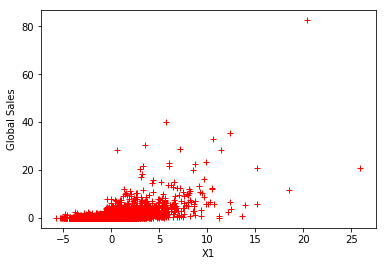

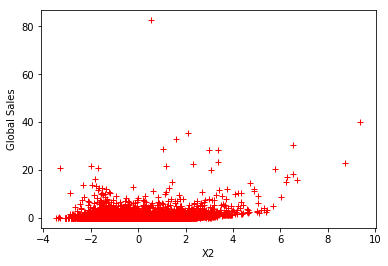

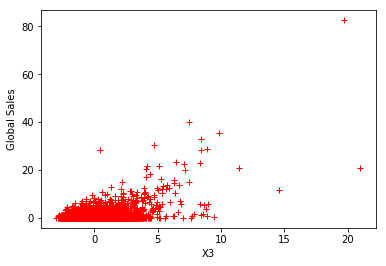

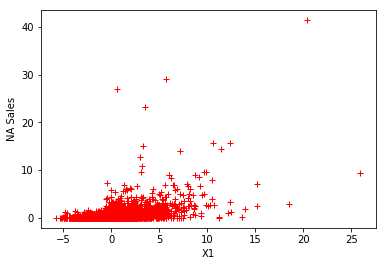

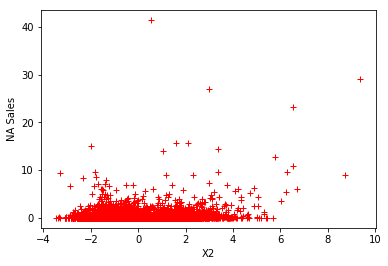

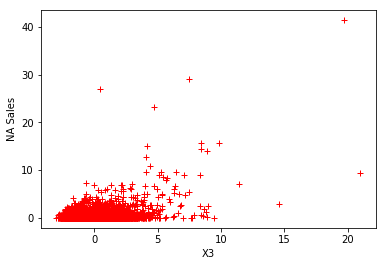

In [48]:
plt.xlabel('X1')
plt.ylabel('Global Sales')
plt.plot(X_train_pca[:,0], y_train.Global_Sales, 'r+')
plt.show()

plt.xlabel('X2')
plt.ylabel('Global Sales')
plt.plot(X_train_pca[:,1], y_train.Global_Sales, 'r+')
plt.show()

plt.xlabel('X3')
plt.ylabel('Global Sales')
plt.plot(X_train_pca[:,2],y_train.Global_Sales, 'r+')
plt.show()

plt.xlabel('X1')
plt.ylabel('NA Sales')
plt.plot(X_train_pca[:,0],y_train.NA_Sales, 'r+')
plt.show()

plt.xlabel('X2')
plt.ylabel('NA Sales')
plt.plot(X_train_pca[:,1],y_train.NA_Sales, 'r+')
plt.show()

plt.xlabel('X3')
plt.ylabel('NA Sales')
plt.plot(X_train_pca[:,2],y_train.NA_Sales, 'r+')
plt.show()

En observant les relations entre les variables explicatives et nos données à prédire, on observe que la relation linéaire que l'on souhaitait observer n'est pas si évidente, et qu'il est possible de faire passer une multitude de droites sur chacuns des graphes. Néanmoins, il ne se distingue pas non plus de relations non linéaire, comme un relation polynomiale par exemple, c'est pourquoi nous n'avons pas exploré la regression polynomiale.

On observe également des outliers qui semblent très suspects, ou du moins qui se détachent beaucoup du reste des données.

### Alternative à l'ACP basique ? 

Une piste d'amélioration de notre modèle a été de ne pas utiliser une ACP classique, mais plutôt d'utiliser une ACP par variable catégorielle (*platform*, *genre*, etc.). En effet, puisque ces variables sont représentés non pas par une colonne mais plusieurs, l'importance de chaque feature pouvait être trop "dilué" dans l'ACP globale, et réduire la dimension en faisant une ACP pour chacune des composantes sur laquelle on a effectué un *one-hot encoding* a été essayé.

Cependant, nous ne conservons pas cette méthode car celle-ci donnait un score en validation croisée similaire, alors qu'elle conservait beaucoup plus de colonnes.

# V. Analyse de la regression par ACP

### V.1. Courbe d'ajustement

Un premier moyen d'analyser notre régression est d'afficher la courbe d'apprentissage :

On divise le jeu de données en deux (ensemble d'entraînement et de validation), et pour $i$ allant 1 à $n_{train}$, où $n_{train}$ est là taille de l'ensemble d'entraînement, on entraine les i premières valeurs de cet ensemble, et on observe le score sur celui-ci ainsi que sur l'ensemble de validation.

On peut donc afficher deux courbes qui correspondent au RMSE pour l'ensemble d'entraînement et l'ensemble de validation, en fonction de la taille de l'ensemble d'entraînement. On s'attend alors à observer une courbe croissante pour l'ensemble d'entrainement, car plus on ajoute de données à entraîner, plus il va être difficile d'y fitter une courbe, et une courbe décroissante pour l'ensemble de validation, car plus on a de données d'entrainement, mieux on pourra (en théorie) prévoit ces valeurs. Ainsi, en fonction du palier que ces fonctions atteignent et de l'écart entre ces deux courbes, on peut en déduire que notre modèle fait du sous-apprentissage, ou du sur-apprentissage.

In [49]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    A_train, A_val, b_train, b_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(A_train)):
        model.fit(A_train[:m], b_train[:m])
        b_train_predict = model.predict(A_train[:m])
        b_val_predict = model.predict(A_val)
        train_errors.append(mean_squared_error(b_train[:m], b_train_predict))
        val_errors.append(mean_squared_error(b_val, b_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14) 

Voici ce que l'on affiche :

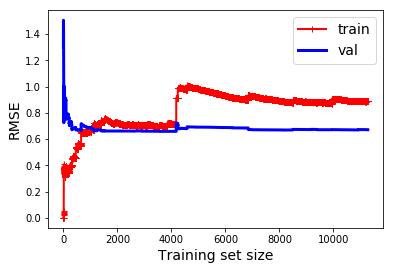

In [50]:
plot_learning_curves(lm1, X_train_pca, y_train.Global_Sales)
# plt.axis([0, 10000, 0, 0.8])
plt.show()

Ce que l'on observe est pour le moins déroutant : en effet, pour une grande valeur de l'ensemble d'entraînement, on effectue une erreur bien plus grande sur ce même ensemble que sur un ensemble de validation !

Ceci ne peut-être expliqué que par un seul phénomène, dont l'intuition est donné par les '*steps*' dans la courbe : des *outliers* sont présents dans l'ensemble d'entraînement, et ces outliers augmentent considérablement le RMSE de l'ensemble d'entraînement.

### V.2. Valeurs suspectes ?

Nous allons dans cette partie déterminer les outliers du modele de régression linéaire.

Commencons par établir la liste des données suspectes avec la fonction *find_susp*, qui retourne les résidus studentisés des predictions :

In [51]:
def find_susp(X, Y, Y_pred):
    H = X @ np.linalg.inv(np.transpose(X) @ X) @ np.transpose(X)
    n = X.shape[0]
    p = X.shape[1]
    sigma2 = (np.sum((Y-Y_pred)**2)/(n-p-1))
    
    f = (lambda e, h: (e/np.sqrt(sigma2*(1-h))))
              
    return f(Y-Y_pred, np.diagonal(H))
              
y_NA_pred = lm1.predict(X_train_pca)

y_NA_train = y_train["NA_Sales"]

susp = pd.DataFrame()

susp["Name"] = Names
susp["RS"] = np.abs(find_susp(X_train_pca, y_NA_train, y_NA_pred)) # residus studentises


Voici les plus gros outliers que l'on trouve avec cet méthode, et leurs résidus associés :

In [52]:
susp = susp.sort_values("RS", ascending=[0])
susp.head()

,Name,RS
1975,Grand Theft Auto: San Andreas,34.442813
2161,Gran Turismo 4,30.206346
4730,Duck Hunt,23.850233
11742,Animal Crossing: Wild World,16.065797
110,Brain Age: Train Your Brain in Minutes a Day,15.152540


Il reste a déterminer quelles valeurs nous devons retirer de notre dataset selon un seuil de résidu de student (RS) acceptable. Dans le cours, nous avons comme valeur par défaut la valeur 3; cependant, il nous a paru trop arbitraire d'appliquer ce critère sans analyse plus approfondie. C'est pourquoi nous avons réalisé la fonction *find_best_rs_threshold* qui détermine le score de la regression (le MSE) selon le seuil que l'on choisit pour le RS. cette fonction trace également la courbe du MSE en fonction de RS.

Pour ce faire, on applique la même méthode que pour la courbe d'apprentissage : on divise notre jeu de données en ensemble entraînement/validation, puis l'on fait varier la valeur limite de RS que l'on rejette dans l'ensemble d'entraînement, et on observe le score.

Les arguments de cette fonction sont :

* X : les données prétraitées
* Y : la variable que l'on souhaite prédire
* rst_init : le seuil de résidu de student a partir duquel on souhaite commencer l'exploration
* rst_increment : le pas sur le rst
* rst_max : le seuil de résidu de student d'arrêt de l'exploration (généralement la valeur la plus élevée du dataset)
* seed : permet la division aléatoire de l'ensemble des données en ensemble d'entraînement de validation
* nb_intern_iter : nombre de divisions aléatoires des données en ensemble d'entraînement de validation (cela revient en quelque sorte à faire une validation croisée avec des ensembles d'entrâinement et de validation aléatoires)

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

def find_best_rs_threshold(X, Y, susp, rst_init, rst_increment, rst_max, seed = 0, nb_intern_iter = 1):
    rst = rst_init # seuil des residus studentises
    l_rst = [] # liste des seuils de residus studentises
    l_mean_mse = []
    # on ajoute une colonne a X et a Y correspondant aux residus studentises que l'on supprimera par la suite

    X = pd.DataFrame(X)
    Y = pd.DataFrame(Y)
    
    X["RS"] = susp["RS"]
    Y["RS"] = susp["RS"]
    
    while rst < rst_max:
        l_mse = []
        
        for i in range(nb_intern_iter):
            # on scinde les X en train et validation
            X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=i+seed)
            # on supprime uniquement dans X_train les valeurs ayant un rs superieur a rst
            
            X_train = X_train[X_train["RS"] < rst]
            Y_train = Y_train[Y_train["RS"] < rst]
                        
            # la colonne RS ne doit pas etre prise en compte comme feature
            #print(X_train.columns)
            X_train = X_train.drop(columns = ["RS"])
            X_val = X_val.drop(columns = ["RS"])
            
            lm = linear_model.LinearRegression()
            lm.fit(X_train, Y_train)

            mse = mean_squared_error(Y_val, lm.predict(X_val))
            l_mse.append(mse)
            
            
        l_mean_mse.append(np.mean(l_mse))  
        l_rst.append(rst)
        rst += rst_increment
        
    plt.plot(l_rst, l_mean_mse)
    plt.xlabel("rs threshold")
    plt.ylabel("mean MLE")
    
    plt.show()
        
    return l_rst[np.argmin(l_mean_mse)]

rst_max = np.max(susp["RS"])

En faisant des observations, nous avons constaté que la façon dont on séparait les données en ensemble d'entraînement et de validation était cruciale. En particulier, la présence des plus gros outliers (par exemple le jeu "*GTA San Andreas*") dans l'ensemble d'entraînement ou de validation était capital.

On commence par faire le test en ayant GTA San Andreas dans l'ensemble d'entraînement. (nous avons vérifié expérimentalement que c'était le cas avec le seed par défaut).

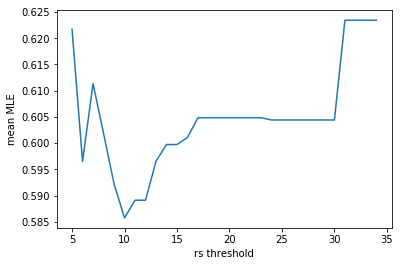

In [54]:
best_rst = find_best_rs_threshold(X = X_train_pca, 
                                  Y = y_train, 
                                  susp = susp, 
                                  rst_init = 5, 
                                  rst_increment = 1, 
                                  rst_max = rst_max)

On remarque que plus on ajoute des éléments ayant un résidu de student élevé, plus le MSE augmente.

Faisons maintenant le test pour GTA dans l'ensemble de validation :

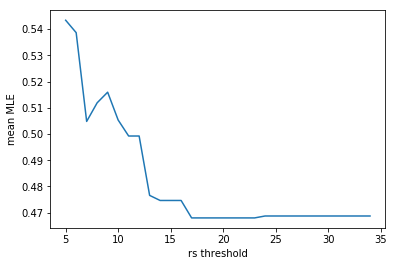

In [58]:
best_rst = find_best_rs_threshold(X = X_train_pca, 
                                  Y = y_train, 
                                  susp = susp, 
                                  rst_init = 5, 
                                  rst_increment = 1, 
                                  rst_max = rst_max,
                                  seed = 12)
y_train = y_train.drop(columns=["RS"])

On remarque le phénomene inverse.

### Interprétation du résultat et ouverture

On a remarqué que notre décision sur le seuil de résidu de student est grandement influencé par la présence de GTA (la valeur la plus suspecte du dataset) dans l'ensemble de validation. Si GTA est présent dans l'ensemble de validation, il est recommandé de garder toutes les valeurs à haut rs pour mieux prédire GTA, et inversement. Cette observation n'est d'ailleurs pas spécifique à GTA, mais à tout les jeux qui apparaissent comme outliers, et qui souvent sont des jeux qui ont été énormément vendus mais qui ont chacuns des tendances très spécifiques en fonction du continent.

Cela nous indique qu'on devrait classer les jeux sous deux catégories : les outliers et les autres jeux. On effectuerait alors deux régressions distinctes sur ces deux sous ensembles des données.

Nous devrions maintenant trouver une façon de classer les jeux selon selon le caractere "Outlier". Pour cela, nous effectuerions une régression logistique avec comme variable a prédire les résidus de student que nous avons trouvés avec le modèle linéaire précédent. Une fois le résidu de student prédit, nous pourrions séparer le dataset en deux groupes selon le seuil déterminé dans la partie précédente (10 lorsque GTA n'est pas dans l'ensemble de validation). Enfin, on appliquerait le modele linéaire que l'on utilise ici sur les jeux qui auraient déjà bien été 'expliqués' par celui-ci (c'est à dire avec un RS prédit faible), et un modèle différent sur les outliers.

Puisque nous n'explorons pas cette piste jusqu'au bout, nous allons effectuer des régressions linéaires par classe pour chaque variable qualitative. L'idée derrière est que la relation entre Y et X peut être très différente selon la classe des observations pour une variable donnée.

# VI. Régression linéaire par classe de chaque variable qualitative 

Nous allons faire cette approche pour les variables Genre, Rating, Publisher, Developer et enfin Platform.

### VI.1 Régression linéaire dépendamment de la variable "Genre" 

In [56]:
Genres = ['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5','Genre6', 'Genre7', 'Genre8', 'Genre9', 'Genre10', 'Genre11', 'Genre12','Genre13']
# lm est un dictionnaire contenant tous les modèles de régression linéaires pour chaque genre, selon chaque Output
lm={}
for (i,j) in enumerate(Genres):
    X = X_train_prepared[X_train_prepared[j] == 1]
    Y = y_train[X_train_prepared[j] == 1]
    lm[str(i)+"_1"] = linear_model.LinearRegression()
    lm[str(i)+"_1"].fit(X,Y.iloc[:,0])
    lm[str(i)+"_2"] = linear_model.LinearRegression()
    lm[str(i)+"_2"].fit(X,Y.iloc[:,1])

Après avoir fait ajuster nos modèles, on prédit désormais pour l'ensemble de test

In [63]:
X_train_prepared.columns[12:25]

Index(['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6', 'Genre7',
       'Genre8', 'Genre9', 'Genre10', 'Genre11', 'Genre12', 'Genre13'],
      dtype='object')

In [64]:
Prediction = pd.DataFrame(np.zeros((X_test_prepared.shape[0],2)),columns=["NA_Sales","Global_Sales"])
for i in range(X_test_prepared.shape[0]):
    X = X_test_prepared
    a = np.where(np.array(X_test_prepared.iloc[i,12:25]) == 1)[0][0]
    Prediction.iloc[i,0] = lm[str(a)+"_1"].predict(X.iloc[[i]])
    Prediction.iloc[i,1] = lm[str(a)+"_2"].predict(X.iloc[[i]])

Nous transformons par la suite les valeurs négatives en valeurs nulles.

In [65]:
for i in range(Prediction.shape[0]):
    if Prediction.iloc[i,0] <0:
        Prediction.iloc[i,0] = 0
    if Prediction.iloc[i,1] <0:
        Prediction.iloc[i,1] = 0

In [67]:
results['NA_Sales'] = Prediction['NA_Sales']
results['Global_Sales'] = Prediction['Global_Sales']
results.to_csv('results.csv', index = False)

### VI.2 Régression linéaire dépendamment du Rating

Nous appliquons la même démarche pour Rating

In [74]:
Ratings = ['Rating1', 'Rating2', 'Rating3', 'Rating4', 'Rating5', 'Rating6']
lm={}
for (i,j) in enumerate(Ratings):
    X = X_train_prepared[X_train_prepared[j] == 1]
    Y = y_train[X_train_prepared[j] == 1]
    lm[str(i)+"_1"] = linear_model.LinearRegression()
    lm[str(i)+"_1"].fit(X,Y.iloc[:,0])
    lm[str(i)+"_2"] = linear_model.LinearRegression()
    lm[str(i)+"_2"].fit(X,Y.iloc[:,1])
Prediction = pd.DataFrame(np.zeros((X_test_prepared.shape[0],2)),columns=["NA_Sales","Global_Sales"])
for i in range(X_test_prepared.shape[0]):
    X = X_test_prepared
    a = np.where(np.array(X_test_prepared.iloc[i,25:31]) == 1)[0][0]
    Prediction.iloc[i,0] = lm[str(a)+"_1"].predict(X.iloc[[i]])
    Prediction.iloc[i,1] = lm[str(a)+"_2"].predict(X.iloc[[i]])
for i in range(Prediction.shape[0]):
    if Prediction.iloc[i,0] <0:
        Prediction.iloc[i,0] = 0
    if Prediction.iloc[i,1] <0:
        Prediction.iloc[i,1] = 0

### VI.3 Régression linéaire dépendamment du Publisher

Nous appliquons la même démarche pour Publisher

In [79]:
Publishers = ['Publisher1', 'Publisher2', 'Publisher3', 'Publisher4',
       'Publisher5', 'Publisher6', 'Publisher7', 'Publisher8', 'Publisher9',
       'Publisher10', 'Publisher11']
lm={}
for (i,j) in enumerate(Publishers):
    X = X_train_prepared[X_train_prepared[j] == 1]
    Y = y_train[X_train_prepared[j] == 1]
    lm[str(i)+"_1"] = linear_model.LinearRegression()
    lm[str(i)+"_1"].fit(X,Y.iloc[:,0])
    lm[str(i)+"_2"] = linear_model.LinearRegression()
    lm[str(i)+"_2"].fit(X,Y.iloc[:,1])
Prediction = pd.DataFrame(np.zeros((X_test_prepared.shape[0],2)),columns=["NA_Sales","Global_Sales"])
for i in range(X_test_prepared.shape[0]):
    X = X_test_prepared
    a = np.where(np.array(X_test_prepared.iloc[i,31:42]) == 1)[0][0]
    Prediction.iloc[i,0] = lm[str(a)+"_1"].predict(X.iloc[[i]])
    Prediction.iloc[i,1] = lm[str(a)+"_2"].predict(X.iloc[[i]])
for i in range(Prediction.shape[0]):
    if Prediction.iloc[i,0] <0:
        Prediction.iloc[i,0] = 0
    if Prediction.iloc[i,1] <0:
        Prediction.iloc[i,1] = 0

### VI.4 Régression linéaire dépendamment de Developer

Nous appliquons la même démarche Pour Developer

In [87]:
Developer = ['Developer1', 'Developer2', 'Developer3', 'Developer4', 'Developer5',
       'Developer6', 'Developer7', 'Developer8', 'Developer9', 'Developer10',
       'Developer11', 'Developer12', 'Developer13', 'Developer14',
       'Developer15', 'Developer16']
lm={}
for (i,j) in enumerate(Developer):
    X = X_train_prepared[X_train_prepared[j] == 1]
    Y = y_train[X_train_prepared[j] == 1]
    lm[str(i)+"_1"] = linear_model.LinearRegression()
    lm[str(i)+"_1"].fit(X,Y.iloc[:,0])
    lm[str(i)+"_2"] = linear_model.LinearRegression()
    lm[str(i)+"_2"].fit(X,Y.iloc[:,1])
    
Prediction = pd.DataFrame(np.zeros((X_test_prepared.shape[0],2)),columns=["NA_Sales","Global_Sales"])
for i in range(X_test_prepared.shape[0]):
    X = X_test_prepared
    a = np.where(np.array(X_test_prepared.iloc[i,42:58]) == 1)[0][0]
    Prediction.iloc[i,0] = lm[str(a)+"_1"].predict(X.iloc[[i]])
    Prediction.iloc[i,1] = lm[str(a)+"_2"].predict(X.iloc[[i]])
    
for i in range(Prediction.shape[0]):
    if Prediction.iloc[i,0] <0:
        Prediction.iloc[i,0] = 0
    if Prediction.iloc[i,1] <0:
        Prediction.iloc[i,1] = 0

### VI.5 Régression linéaire dépendamment de Platform

Nous appliquons la même démarche pour Platform

In [97]:
Platform = ['Platform1', 'Platform2', 'Platform3', 'Platform4', 'Platform5',
       'Platform6', 'Platform7', 'Platform8', 'Platform9', 'Platform10',
       'Platform11', 'Platform12', 'Platform13', 'Platform14', 'Platform15']
lm={}
for (i,j) in enumerate(Platform):
    X = X_train_prepared[X_train_prepared[j] == 1]
    Y = y_train[X_train_prepared[j] == 1]
    lm[str(i)+"_1"] = linear_model.LinearRegression()
    lm[str(i)+"_1"].fit(X,Y.iloc[:,0])
    lm[str(i)+"_2"] = linear_model.LinearRegression()
    lm[str(i)+"_2"].fit(X,Y.iloc[:,1])
    
Prediction = pd.DataFrame(np.zeros((X_test_prepared.shape[0],2)),columns=["NA_Sales","Global_Sales"])
for i in range(X_test_prepared.shape[0]):
    X = X_test_prepared
    a = np.where(np.array(X_test_prepared.iloc[i,58:73]) == 1)[0][0]
    Prediction.iloc[i,0] = lm[str(a)+"_1"].predict(X.iloc[[i]])
    Prediction.iloc[i,1] = lm[str(a)+"_2"].predict(X.iloc[[i]])
    
for i in range(Prediction.shape[0]):
    if Prediction.iloc[i,0] <0:
        Prediction.iloc[i,0] = 0
    if Prediction.iloc[i,1] <0:
        Prediction.iloc[i,1] = 0

- Conclusion intermédiaire:

Selon nos soumissions sur Kaggle pour chacun des 5 cas, nous remarquons que la démarche qui donne le plus petit RMSE concerne la variable Platform.

### Ouverture sur une autre idée :  

Nous arrivons à améliorer le score sur Kaggle avec cette méthode. Cependant, remarquons que nous n'utilisons pas le lien entre les 2 variables de sortie alors qu'elles sont fortement corrélées. Analysons les résultats de la régression linéaire de NA Sales sur à Global Sales:

In [0]:
import statsmodels.api as sm
X = sm.add_constant(y_train.Global_Sales)
model_na_sales = sm.OLS(y_train.NA_Sales, X).fit()

print(model_na_sales.summary())

                            OLS Regression Results                            
Dep. Variable:               NA_Sales   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.139e+05
Date:                Tue, 11 Dec 2018   Prob (F-statistic):               0.00
Time:                        23:30:23   Log-Likelihood:                -1864.5
No. Observations:               14094   AIC:                             3733.
Df Residuals:                   14092   BIC:                             3748.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0078      0.002     -3.164   

Nous retrouver que $R^2$ de cette regression linéaire est de 89%: 89% de la variabilité de NA Sales est expliquée par Global Sales.

Il nous faut alors un modèle qui prend en compte la relation en X et Y. Nous utiliserons alors les réseaux de neuronnes qui permettent de capturer généralement la relation entre les différentes composantes de Y.

# VII. Réseaux de neurones

Nous choisissons d'utiliser les réseaux de neuronnes puisqu'ils permettent de capturer la relation entre NA Sales et Global Sales. Nous ferons par la suite une petite introduction théorique aux réseaux de neuronnes que vous pouvez retrouver avec plus de détails dans la référence 4:

Remarque: 2 membres de l'équipe suivent le cours "Méthodes statistiques d'apprentissage" et donc ils sont déjà été exposés à la théorie des réseaux de neuronnes et leurs utilisation dans le logiciel R.

### VII.1. Introduction à la théorie des réseaux de neurones (ref.4): 

Un réseau neuronal est l’association, en un graphe plus ou moins complexe, d’objets élémentaires, les neurones formels. Les principaux réseaux se distinguent par l’organisation du graphe, c’est-à-dire leur architecture (nombre de couches par exemple), son niveau de complexité (le nombre de neurones par exemple), par le type des neurones (leurs fonctions de transition ou d’activation) et enfin par l’objectif visé : apprentissage supervisé ou non, optimisation, systèmes dynamiques...

Dans le contexte de ce projet, nous utilisons ce qu'on appelle le perceptron multicouche.

#### VII.1.i. Définition du perceptron multicouche et architecture(ref.4): 

Le perceptron multicouche (PMC) est un réseau composé de couches successives. Une couche est un ensemble de neurones n’ayant pas de connexion entre eux. Une couche d’entrée lit les signaux entrant, un neurone par entrée $x_j$, une couche en sortie fournit la réponse du système. Une ou plusieurs couches cachées participent au transfert. Dans un perceptron, un neurone d’une couche cachée est connecté en entrée à chacun des neurones de la couche précédente et en sortie à chaque neurone de la couche suivante.

#### VII.1.ii. Fonction de transfert(ref.4):

Les entrées d’un réseau sont encore notées $X_1$, . . . , $X_p$ comme les variables explicatives d’un modèle tandis que les poids des entrées sont des paramètres $\alpha$, $\beta$ à estimer lors de la procédure d’apprentissage et que la sortie est la variable $Y$ à expliquer ou cible du modèle.

Un perceptron multicouche réalise donc une transformation des variables d’entrée : $Y = f(X_1, . . . , X_p; \alpha)$ où $\alpha$ est le vecteur contenant chacun des paramètres $\alpha_{jkl}$ de la $j^{ème}$ entrée du $k^{ème}$ neurone de la $l^{ème}$ couche ; la couche d’entrée (l = 0) n’est pas paramétrée, elle ne fait que distribuer les entrées sur tous les neurones de la couche suivante. Un théorème dit d’approximation universelle montre que cette structure élémentaire à une seule couche cachée est suffisante pour prendre en compte les problèmes classiques de modélisation ou apprentissage statistique. En effet, toute fonction régulière peut être approchée uniformément avec une précision arbitraire et dans un domaine fini de l’espace de ses variables, par un réseau de neurones comportant une couche de neurones cachés en nombre fini possédant tous la même fonction d’activation et un neurone de sortie linéaire.

De façon usuelle et en régression (Y quantitative), la dernière couche est constituée d’un seul neurone muni de la fonction d’activation identité tandis que les autres neurones (couche cachée) sont munis de la fonction sigmoïde.

Ainsi, en régression avec un perceptron à une couche cachée de $q$ neurones et un neurone de sortie, cette fonction s’écrit :
$ y = f(x; \alpha, \beta) = \beta_0 + \beta' z $ avec $z_k= g( \alpha_{k0} + \alpha_{k}' x)$ , k= 1,..,q. 

#### VII.1.iii. Apprentissage(ref.4):

Supposons que l’on dispose d’une base d’apprentissage de taille n d’observations $(x_i^1,..,x_i^p;y_i)$ des variables explicatives $X^1, . . . , X^p$ et de la variable à prévoir $Y$. Considérons le cas le plus simple de la régression avec un réseau
constitué d’un neurone de sortie linéaire et d’une couche à q neurones dont les paramètres sont optimisés par moindres carrés. Ceci se généralise à toute fonction perte dérivable et donc à la discrimination à m classes.

L’apprentissage est l’estimation des paramètres $\alpha_{j=0,p;k=1,q}$ et $\beta_{k=0,q}$ par minimisation de la fonction perte quadratique: $Q(\alpha, \beta) = \sum_{i=1}^{n} [y_i − f(x; \alpha, \beta)]^2$. 

Différents algorithmes d’optimisation sont proposés, ils sont généralement basés sur une évaluation du gradient par rétro-propagation.

**Rétro-propagation de l’erreur :**

Il s’agit donc dévaluer la dérivée de la fonction coût en une observation et par rapport aux différents paramètres. Soit $z_{ki} = g(\alpha_{k0} + \alpha_{k}' x_i)$ et $z_i = {z_{1i}, . . . , z_{qi}}$. Les dérivées partielles de la fonction perte quadratique s’écrivent :

$$∂Q_i  / ∂ \beta_k = −2(y_i − φ(x_i))(β'z_i)z_{ki} = δ_i z_{ki}$$.

et 

$$∂Q_i /  ∂ \alpha_{kj} = −2(y_i − φ(x_i))(\beta'z_i)\beta_k g'(\alpha_k' x_i)x_{ip} = s_{ki} x_{ip}$$.

Les termes δ_i et s_{ki} sont respectivement les termes d’erreur du modèle courant à la sortie et sur chaque neurone caché. Ces termes d’erreur vérifient les équations dites de rétro-propagation :

$$s_{ki} = g'(\alpha_k' x_i)\beta_k δ_i$$

dont les termes sont évalués en deux passes. Une passe avant, avec les valeurs courantes des poids : l’application des différentes entrées $x_i$ au réseau permet de déterminer les valeurs ajustées $\hat{f}(x_i)$. La passe retour permet ensuite de
déterminer les $δ_i$ qui sont rétro-propagés afin de calculer les $s_{ki}$ et ainsi obtenir les évaluations des gradients.

**Algorithmes d’optimisation :**

Sachant évaluer les gradients, différents algorithmes, plus ou moins sophistiqués, sont implémentés. Le plus élémentaire est une utilisation itérative du gradient : en tout point de l’espace des paramètres, le vecteur gradient de Q pointe dans la direction de l’erreur croissante. Pour faire décroître Q il suffit donc de se déplacer en sens contraire. D’autres algorithmes encore sont des versions adaptatives. Lorsque de nouvelles observations sont proposées une à une au réseau. Dans ce dernier type d’algorithme, des propriétés de dynamique markovienne (processus ergodique convergeant vers la mesure stationnaire) impliquent une convergence presque sûre : la probabilité d’atteindre une précision fixée a priori tend vers 1 lorsque la taille de l’échantillon d’apprentissage tend vers l’infini.

**Vous pouvez consulter la référence 4 pour plus de détails**.


### VII.2. Application des réseaux de neuronnes à notre problème:

Nous avons constaté à partir de l'analyse précédente que faire un modèle de regression par catégorie de la variable "platform" était le plus efficace. Dans la même optique, nous allons entrainer un réseau de neurones par catégorie de cette variable et faire les prédictions selon cette catégorie.

In [98]:
from sklearn.neural_network import MLPRegressor

Nous utiliserons la variable Platform puisqu'à priori, c'est la colonne qui nous a donné le meilleur RMSE sur Kaggle avec Régression Linéaire.

In [100]:
Platform = ['Platform1',
       'Platform2', 'Platform3', 'Platform4', 'Platform5', 'Platform6',
       'Platform7', 'Platform8', 'Platform9','Platform10','Platform11','Platform12','Platform13','Platform14','Platform15']
# NN est un dictionnaire contenant tous les modèles de réseaux de neurones pour chaque genre
NN={}
for (i,j) in enumerate(Platform):
    X = X_train_prepared[X_train_prepared[j] == 1]
    Y = y_train[X_train_prepared[j] == 1]
    NN[str(i)] = MLPRegressor(hidden_layer_sizes=(100,50))
    NN[str(i)].fit(X,Y)
    
Prediction = pd.DataFrame(np.zeros((X_test_prepared.shape[0],2)),columns=["NA_Sales","Global_Sales"])
for i in range(X_test_prepared.shape[0]):
    X = X_test_prepared
    a = np.where(np.array(X_test_prepared.iloc[i,58:73]) == 1)[0][0]
    Prediction.iloc[i,:] = NN[str(a)].predict(X.iloc[[i]])
    
for i in range(Prediction.shape[0]):
    if Prediction.iloc[i,0] <0:
        Prediction.iloc[i,0] = 0
    if Prediction.iloc[i,1] <0:
        Prediction.iloc[i,1] = 0

In [ ]:
results['NA_Sales'] = Predict['NA_Sales']
results['Global_Sales'] = Predict['Global_Sales']
results.to_csv('results_NN.csv', index = False)

# VIII. Évolution du résultat et Conclusions

Avant d'aboutir à cette version finale, beaucoup de tentatives ont été effectués tout au long du projet : nous sommes néanmoins toujours resté sur une approche "classique" et non bayesienne, car nous avons préféré exploiter au maximum toutes nos idées pour améliorer ce que nous avions fait, plutôt que repartir de 0.

L'organisation que nous souhaitions avoir était la suivante : nous souhaitions partir d'un modèle très simple avec très peu de variables, et l'enrichir au fur et à mesure en fonction des résultats que nous obtenons pour essayer de diminuer le score. Cependant, les résultats que nous obtenions nous ont beaucoup interrogés, en particulier en début de projet.

###### Chronologie des améliorations : 

* 1ère tentative : on construit le squelette du code permettant d'effectuer une regression linéaire à partir de variables continues (modèle le plus simple, pas d'encodage, d'ACP, etc), en *droppant* les NaN values.
* On ajoute ensuite au fur et à mesure les autres variables (discrètes, etc.), et on effectue un traitement des données (normalisation, remplissage des NaN Values, etc)
* On gère la multicolinéarité : utilisation de l'ACP
* On applique la validation croisée pour utilisé le meilleur paramètre dans chacune des étapes
* Ensuite, on aborde diverses pistes d'améliorations pour tenter d'améliorer notre score : modèle linéaire généralisés, changement dans l'ACP, isolement de données pour effectués plusieurs modèles de regressions, sélection de variables, etc.
* Finalement, on utilise des réseaux de neuronnes pour exploiter leurs caractéristiques particulières.

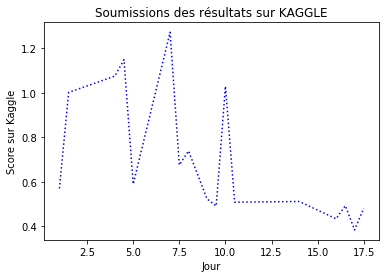

In [5]:
submissions = [0.56974, 1.00207, 1.07525, 1.14955, 
               0.58889, 1.27302, 0.67517, 0.73865,
               0.52266, 0.49055, 1.02971, 0.50777,
               0.51087, 0.43299, 0.49193, 0.38281,
               0.48082]

index_submit = [1, 1.5, 4, 4.5, 5, 7, 7.5, 8, 9, 9.5, 10,
                10.5, 14, 16, 16.5, 17, 17.5]

plt.title('Soumissions des résultats sur KAGGLE')
plt.xlabel('Jour')
plt.ylabel('Score sur Kaggle')
plt.plot(index_submit, submissions, 'b:')

Ce graphe nous montre l'évolution du score que nous obtenions sur Kaggle en fonction du temps.

On observe ainsi ce qui nous a dérouté au début du projet : notre premier essai, le plus simple possible, a eut un score plutôt bon (0.56974), et nous avons mis plus d'une semaine avant de l'améliorer !

Ainsi, même après avoir corrigé toutes les erreurs dans le code, inclure toutes les variables, les traités, et effectué une PCA ne nous a pas permis d'améliorer le score (0.58889). C'est donc après une semaine que nous nous sommes divisés les tâches et que chacun a essayé de trouver une piste d'amélioration. Et le score a été finalement amélioré lorsque l'on a effectué une regression par catégorie d'une variable catégorielle (0.49055 lorsqu'on utilise *platform*). Cependant, beaucoup de nos approches n'ont pas abouti, certaines n'ont pas amélioré le score sur Kaggle et d'autres avaient un score en validation croisée trop elevée pour pouvoir même essayer de soumettre le résultat. 
La dernière difficulté a été ensuite de mettre en commun toutes les idées exploités, et de faire le tri sur ce les améliorations que l'on conservait ou non.

Finalement, le meilleur score que nous avons obtenu sur Kaggle était 0.38281 en utilisant les réseaux de neuronnes qui ont permis d'exploiter la corrélation entre les variables de sortie.

# Références:

(ref.1) https://datascience.stackexchange.com/questions/10459/calculation-and-visualization-of-correlation-matrix-with-pandas  
(ref.2) Traitement des données dans la matière INF8215.  
(ref.3) https://xavierbourretsicotte.github.io/subset_selection.html
(ref.4) https://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-m-app-rn.pdf